In [1]:
# loading libraries

import pandas as pd
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV as GridSearch


/home/gonzalodiz/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Entre cada uno de los integrantes del grupo fuimos obteniendo distintos features que nos parecieron interesantes y que consideramos que podrian servir para las predicciones.

#### Leemos los distintos CSVs que contienen los features


In [2]:
features_gaby = pd.read_csv('../features/features_gaby.csv')
features_gonza = pd.read_csv('../features/features_gonza.csv').drop(columns='Unnamed: 0')
features_ari = pd.read_csv('../features/features_ariel.csv')
features_mati = pd.read_csv('../features/features_frecuencia.csv')
labels_training_set = pd.read_csv('../dataset/labels_training_set.csv')
test_set = pd.read_csv('../dataset/trocafone_kaggle_test.csv')
features_gonza2 = pd.read_csv('../features/features_gonza2.csv')

## Mergeamos todos los features en un solo dataframe de la forma <persona, feature1, feature2,...,...>

In [3]:
#model_df = pd.merge(features_gaby, features_gonza, how='inner', on='person')
model_df = pd.merge(features_gaby, features_ari, how='inner', on='person')
model_df = pd.merge(model_df, features_gonza, how='inner', on='person')
model_df = pd.merge(model_df, features_gonza2, how='inner', on='person')
#model_df = pd.merge(model_df, features_mati, how='inner', on='person')
model_df.head()

,person,marca_favorita_apple,marca_favorita_asus,marca_favorita_lenovo,marca_favorita_lg,marca_favorita_motorola,marca_favorita_no tiene,marca_favorita_quantum,marca_favorita_samsung,marca_favorita_sony,...,cantidad_checkouts,cantidad_conversions,tasa_cc,cantidad_lead,cantidad_searchs,month_moda,favorite_device_Computer,favorite_device_Smartphone,favorite_device_Tablet,favorite_device_Unknown
0,0008ed71,1,0,0,0,0,0,0,0,0,...,3.0,NaN,NaN,NaN,NaN,5,1,0,0,0
1,00091926,1,0,0,0,0,0,0,0,0,...,2.0,NaN,NaN,NaN,NaN,5,1,0,0,0
2,00091a7a,1,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,3,0,1,0,0
3,000ba417,0,0,0,0,0,0,0,1,0,...,6.0,1.0,0.166667,NaN,NaN,5,1,0,0,0
4,000c79fe,1,0,0,0,0,0,0,0,0,...,1.0,NaN,NaN,NaN,9.0,5,0,1,0,0


In [4]:
model_df.fillna(value=0, inplace=True)

## Al dataframe de las personas con sus features le agregamos los labels para saber si cada persona o no realizo una compra.

## Tambien tenemos un dataframe de test, el cual contiene todas las personas que queremos predecir y sus features ( queremos predecir sus labels)

In [5]:
training_set = pd.merge(model_df, labels_training_set, how='inner', on='person')
test_set = pd.merge(model_df, test_set, how='inner', on='person')
#training_set.drop(columns= 'Unnamed: 0', inplace=True)

## Como se puede observar en nuestro set de entrenamiento predomina el label 0, la mayoria de las personas no realizo una conversion, esto debemos balancearlo.

In [6]:
training_set['label'].value_counts()

0    18434
1      980
Name: label, dtype: int64

## Elimino 17500 filas que contienen el label 0 para balancear el set de entrenamiento.

# <font color='red'> Preguntar de cual es la mejor manera de hacer esto</font>

In [7]:
#training_set.sort_values(by='month_moda', ascending=True, inplace=True)
#r_training_set = training_set.drop(training_set[training_set.label.eq(0)].head(17500).index)

In [8]:
r_training_set = training_set.drop(training_set[training_set.label.eq(0)].sample(17454).index)
r_training_set['label'].value_counts()

1    980
0    980
Name: label, dtype: int64

In [9]:
r_training_set.month_moda.value_counts()

5    1541
4     198
3     133
2      46
1      42
Name: month_moda, dtype: int64

In [10]:
training_set['month_moda'].value_counts()

5    17242
4     1044
3      643
2      274
1      211
Name: month_moda, dtype: int64

In [11]:
r_training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1960 entries, 6 to 19397
Data columns (total 59 columns):
person                                   1960 non-null object
marca_favorita_apple                     1960 non-null int64
marca_favorita_asus                      1960 non-null int64
marca_favorita_lenovo                    1960 non-null int64
marca_favorita_lg                        1960 non-null int64
marca_favorita_motorola                  1960 non-null int64
marca_favorita_no tiene                  1960 non-null int64
marca_favorita_quantum                   1960 non-null int64
marca_favorita_samsung                   1960 non-null int64
marca_favorita_sony                      1960 non-null int64
nivel_de_actividad_Muy Bajo              1960 non-null int64
nivel_de_actividad_Bajo                  1960 non-null int64
nivel_de_actividad_Medio                 1960 non-null int64
nivel_de_actividad_Alto                  1960 non-null int64
nivel_de_actividad_Muy Alto          

## En el siguiente array incluimos los features que mas aportan para las predicciones

In [12]:
features = ['cant_total_eventos', #f1
            #'marca_favorita_apple',#f2
            'mean_events_per_day',#f3
            'has_converted_before',#f4
            'most_viewed_sku',#f5
            #'most_viewed_color_Preto',#f6
            #'most_viewed_color_Branco',#f7
            #'most_viewed_color_Dourado', #f8
            #'region_brasil_Sao Paulo',#f9
            #'region_brasil_Unknown',#f10
            #'region_brasil_Minas Gerais',#f11
            #'marca_favorita_samsung',#f12
            'cant_ev_noche',#f13
            'cant_ev_manana',#f14
            'cant_ev_tarde',#f15
            'cant_ev_madrugada',#f16
            'cant_buenos',#f17
            'cant_muy_buenos',#f18
            'cant_excelentes',#f19
            #'nivel_de_actividad_Muy Bajo',#f20
            #'nivel_de_actividad_Muy Alto',#f21
            #'nivel_de_actividad_Bajo',#f22
            #'nivel_de_actividad_Medio',#f23
            #'nivel_de_actividad_Alto',#f24
            #'favorite_device_Smartphone',#f25
            'favorite_device_Computer',#f26
            'cantidad_checkouts',#f27
            'cantidad_conversions',#f28
            #'tasa_cc',
            #'cantidad_lead',
            'cantidad_searchs',
            'month_moda'
           ]

## Creo dos arrays el llamado X es generado a partir de mi dataframe de entrenamiento y los features que quiero tener en cuenta
## Y el segundo Y es generado a partir de sus labels

In [13]:
x = np.array(r_training_set[features])
y = np.array(r_training_set['label'])

## Usamos train_test_split para dividir el dataframe de entrenamiento en uno de test y otro de entrenamiento

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.10)

## El primer algoritmo que utilizamos es KNN

### En el siguiente loop iremos probando KNN con distintos Ks y nos quedaremos con la que obtuvimos mayor accuracy.

In [15]:
best_accuracy = 0
worst_accuracy = 1
best_k = 1
worst_k = 0
best_prediction = []
#acumulated_acuracy = 0
#loop_count = 0;

for i in xrange(1,203,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = (knn.predict_proba(X_test)[:,1])
    accuracy = accuracy_score(y_test,pred.round(), normalize=False)
    if (accuracy > best_accuracy) :
        best_k = i
        best_accuracy = accuracy
        best_prediction = pred
    if (accuracy < worst_accuracy) : 
        worst_accuracy = accuracy
        worst_k = i
    #loop_count += 1
    #acumulated_acuracy += accuracy
    #X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.10)
        

In [16]:
print 'Best accuracy: ' + str(best_accuracy / float(best_prediction.size)) + ' with k='  + str(best_k)
print 'Worst accuracy: ' + str(worst_accuracy / float(best_prediction.size)) + ' with k= ' + str(worst_k)
#print "Median accuracy " + str(acumulated_acuracy / (float(loop_count) * float(best_prediction.size)))

Best accuracy: 0.6020408163265306 with k=43
Worst accuracy: 0.00510204081633 with k= 0


## Finalmente corremos KNN con el mejor K obtenido en el entrenamiento y el set que queremos predecir

In [17]:
z = np.array(test_set[features])
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x,y)
pred = knn.predict_proba(z)[:,1]

## Le agregamos las predicciones a los IDs de las personas y lo guardamos en un archivo.


In [18]:
persons = test_set['person']
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/knn.csv', index=False)

## Revisamos la cantidad de conversiones y no conversiones predichas

### Se tienen que repartir en un 50/50

In [19]:
no_conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print 'Cantidad de no conversiones: ' + str(no_conversiones)

conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print 'Cantidad de conversiones: ' + str(conversiones)

Cantidad de no conversiones: 12526
Cantidad de conversiones: 6889


## XGBoost

### En los siguientes arrays, ponemos los posibles hiperparametros que concideramos que mejor funcionarian para las predicciones.

### Con grid search probamos todas las combinaciones posibles y nos quedamos con la que mayor accuracy nos dio.

In [20]:
#n_estimators = [100, 200, 1500, 2000]
#max_depth = [2, 4, 6, 8]
#learning_rate = [0.0001, 0.001, 0.01]
#subsample = [0.3, 0.5, 0.7]
#gamma = [0.6, 0.7]
#colsample_bytree = [0.5, 0.7]
min_child_leaf = []
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]

#param_grid = dict(max_depth=max_depth, n_estimators=n_estimators,
#                 learning_rate=learning_rate, subsample=subsample,
#                 gamma=gamma)


In [21]:
#xgboost = xgb.XGBClassifier()
#kfold = StratifiedKFold(n_splits = 2, shuffle=True, random_state=7)
#grid_search = GridSearch(xgboost, param_grid, scoring="neg_log_loss", n_jobs = 1, cv=kfold, verbose=1)
#result = grid_search.fit(x,y)

In [22]:
#pred = (xgboost.predict_proba(z)[:,1])

In [23]:
#pred

In [24]:
#print("Best: %f using %s" % (result.best_score_, result.best_params_))

In [25]:
#means = result.cv_results_['mean_test_score']
#stds = result.cv_results_['std_test_score']
#params = result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#	print("%f (%f) with: %r" % (mean, stdev, param))

### Corremos XGBoost para el set de entrenamiento y medimos su precision

In [26]:
xgboost = xgb.XGBClassifier(learning_rate = 0.001,\
                            n_estimators= 2000,\
                            max_depth= 10,\
                            min_child_weight= 2,\
                            gamma=0.7,\
                            subsample=0.7,\
                            colsample_bytree=0.7,\
                            objective= 'binary:logistic',\
                            scale_pos_weight=1
                           )

xgboost.fit(X_train, y_train)
pred = (xgboost.predict_proba(X_test)[:,1])
accuracy = accuracy_score(y_test, pred.round(), normalize=False)

print("Accuracy: ", accuracy / float(pred.size))

('Accuracy: ', 0.75)


In [27]:
x_test_df = pd.DataFrame(data=X_test, columns=features)
x_test_df['index'] = x_test_df.index
x_label_pred = pd.DataFrame({'label': y_test, 'pred': pred})
x_label_pred['index'] = x_label_pred.index

In [28]:
merged = pd.merge(x_test_df, x_label_pred, how='inner', on='index')
bad_pred = merged.loc[(merged['label'] == 0) & (merged['pred'] >= 0.5)]

In [29]:
bad_pred

,cant_total_eventos,mean_events_per_day,has_converted_before,most_viewed_sku,cant_ev_noche,cant_ev_manana,cant_ev_tarde,cant_ev_madrugada,cant_buenos,cant_muy_buenos,cant_excelentes,favorite_device_Computer,cantidad_checkouts,cantidad_conversions,cantidad_searchs,month_moda,index,label,pred
1,123.0,5.590909,0.0,12744.0,24.0,0.0,30.0,69.0,39.0,17.0,19.0,1.0,1.0,0.0,6.0,5.0,1,0,0.625794
3,142.0,9.466667,0.0,7827.0,83.0,20.0,35.0,4.0,30.0,12.0,5.0,0.0,2.0,0.0,5.0,5.0,3,0,0.592266
13,95.0,2.435897,0.0,10294.0,65.0,0.0,19.0,11.0,33.0,23.0,12.0,1.0,4.0,0.0,0.0,5.0,13,0,0.514576
18,55.0,1.617647,0.0,10897.0,36.0,0.0,19.0,0.0,10.0,26.0,5.0,0.0,1.0,0.0,0.0,4.0,18,0,0.579329
24,228.0,1.652174,0.0,1317.0,80.0,6.0,5.0,137.0,15.0,14.0,35.0,0.0,10.0,0.0,16.0,1.0,24,0,0.710198
33,161.0,7.000000,0.0,7167.0,61.0,0.0,0.0,100.0,44.0,30.0,40.0,1.0,1.0,0.0,0.0,5.0,33,0,0.505136
42,5.0,5.000000,0.0,10336.0,0.0,0.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,42,0,0.659620
52,2.0,2.000000,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,52,0,0.644749
58,92.0,2.787879,1.0,10436.0,37.0,0.0,47.0,8.0,17.0,23.0,32.0,0.0,6.0,7.0,0.0,5.0,58,0,0.568747
67,64.0,1.207547,0.0,10882.0,22.0,7.0,28.0,7.0,20.0,5.0,4.0,0.0,0.0,0.0,1.0,5.0,67,0,0.678972


## Analizamos cuales son los features que mayor peso tienen para xgboost.

In [30]:
print(xgboost.feature_importances_)

[0.09676763 0.12803836 0.01601586 0.14345253 0.08887473 0.02654562
 0.07893782 0.05893127 0.0775663  0.06434658 0.07502677 0.02013043
 0.03796024 0.01267996 0.04400379 0.03072213]


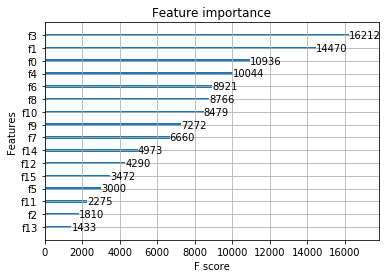

In [31]:
plot = plot_importance(xgboost)
#plot.set_yticklabels(features, fontdict=None, minor=False)
pyplot.show()

In [32]:
xgboost = xgb.XGBClassifier(learning_rate = 0.001,\
                            n_estimators= 2000,\
                            max_depth= 6,\
                            min_child_weight= 2,\
                            gamma=0.7,\
                            subsample=0.7,\
                            colsample_bytree=0.7,\
                            objective= 'binary:logistic',\
                            scale_pos_weight=1
                           )
xgboost.fit(x,y)
pred = (xgboost.predict_proba(z)[:,1])

In [33]:
submit = pd.DataFrame({'label': pred, 'person': persons})
submit = submit[['person', 'label']]
submit.to_csv('../submits/xgboost.csv', index=False)

In [34]:
no_conversiones = submit.loc[submit['label'] < 0.5]['label'].count()
print 'Cantidad de no conversiones: ' + str(no_conversiones)

conversiones = submit.loc[submit['label'] >= 0.5]['label'].count()
print 'Cantidad de conversiones: ' + str(conversiones)

Cantidad de no conversiones: 13432
Cantidad de conversiones: 5983


In [35]:
submit['label'].mean()

0.37432074546813965